<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_04_Understanding_Turbulence_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 05 (b): Understanding GARCH Estimation

### In this section you will:


*   Learn about GARCH estimation and its use in investment management
*   Fit a GARCH Model to currency data
*   Use a GARCH Model forecast volatility


### Intro

GARCH (Generalized Autoregressive Conditional Heteroskedastic) Estimation is used to model the variance of a time series.  Applied to investment management, a GARCH model can be used to model, and therefore predict, asset volatility.  Such models were proposed in "[Generalized Autoregressive Conditional Heteroskedasticity](https://doi.org/10.1016/0304-4076%2886%2990063-1)"

Before we define a GARCH model, consider first an ARCH (Autoregressive Conditional Heteroskedastic) model.  This model assumes that the variance at time $t$ ($\sigma^2_t$) depends linearly on the error $\epsilon_t$,  at a fixed number ($q$) of previous time periods.  When ${q = 1}$ and assuming that the time series ${r_t}$  is stationary with constant mean ${\mu}$ we have the ARCH(1) model:

\begin{eqnarray*}
   r_t    & = & \mu + \epsilon_t \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2
\end{eqnarray*}

More generally for ${q > 1}$ we have ARCH(q):

\begin{eqnarray*}
   \sigma^2_t & = & \omega + \sum_{i=1}^{q}\alpha_i \epsilon_{t-i}^2 
\end{eqnarray*}

The ARCH model captures the idea that the volatility of the series may change through time.  For example, a financial market may exhibit a period of low volatility followed by a period of high volatility. A time series that exhibits periods with increased (or decreased) volatility is called conditional heteroskedastic. 

The ARCH model may be extended to a GARCH model by adding linear dependence on a fixed number ($p$) of past variances.  For ${p = 1}$  and ${q = 1}$ the GARCH(1,1) model is

\begin{eqnarray*}
   r_t    & = & \mu + \epsilon_t \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1}
\end{eqnarray*}

More generally for ${p > 1}$ and ${q > 1}$ we have GARCH(p,q):

\begin{eqnarray*}
   \sigma^2_t & = & \omega + \sum_{i=1}^{q}\alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p}\beta_j \sigma^2_{t-j}
\end{eqnarray*}

## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Pickle (For loading the data)
*   Numpy and Pandas (For data manipulation)
*   Arch (For GARCH estimation)
*   Matplotlib (For time series visualization)

If the packages are not available, install the with "pip install X" or "conda install -c bashtage arch"

In [1]:
import numpy as np, pandas as pd
import pickle
from arch import arch_model
import matplotlib.pyplot as plt

### Read in data from previously stored returns.pkl file



In [2]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### Calculate DXY Index

In this part we scale the DXY Index to avoid numerical instabilities in the model fitting that may arise for inputs near zero.

In [3]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = returns.dot(dxy_weight)
scaled_dxy = 100*dxy
scaled_dxy.head(10)

1975-01-02   -0.263509
1975-01-03    0.298223
1975-01-06   -0.152101
1975-01-07    0.134179
1975-01-08   -0.133663
1975-01-09   -0.062415
1975-01-10    0.028212
1975-01-13   -0.047792
1975-01-14   -0.088794
1975-01-15   -0.144571
dtype: float64

### Estimate a GARCH(1,1) model for the DXY Index

In [4]:
am = arch_model(scaled_dxy, mean = 'Constant', vol='GARCH', p=1, q=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 6811.526379279518
Iteration:     10,   Func. Count:     81,   Neg. LLF: 6805.28464578078
Iteration:     15,   Func. Count:    116,   Neg. LLF: 6797.496139704385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6797.351618871784
            Iterations: 19
            Function evaluations: 136
            Gradient evaluations: 18
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -6797.35
Distribution:                  Normal   AIC:                           13602.7
Method:            Maximum Likelihood   BIC:                           13632.0
                                        No. Observations:                11214
Date:                

The above model corresponds to ${\alpha  = .0422}$,  ${\beta = .9552}$, ${\omega = 9.5954e-04}$ and ${\mu = 1.8657e-03}$ in the frame work described above

\begin{eqnarray}
   r_t    & = & \mu + \epsilon_t \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1}
\end{eqnarray}


### Forecast volatility for the DXY Index

Now we can use this model to forecast the future variance (volatility).

In [5]:
forecasts = res.forecast(horizon = 1)
print(forecasts.variance.index[-1])
print(forecasts.variance.values[-1, -1])

2017-12-26 00:00:00
0.0871872134005918


Next we use a rolling window to forecast the one day volatility.  For each day we use the prior 260 days to fit a GARCH model and forecast a one day horizon.

In [6]:
n_days = 100
lookback_window = 260
horizon = 1
f = []
for i in range(1,n_days+1):
    am = arch_model(scaled_dxy[-i-lookback_window:-i], mean = 'Constant', vol='GARCH', p=1, q=1)
    res = am.fit(disp='off')
    forecasts = res.forecast(horizon = horizon)
    f.append({'var': forecasts.variance.iloc[-1, -1], 'date':forecasts.variance.index[-1]})
    
df_vol_pred = pd.DataFrame(f[::-1])
df_vol_pred.head(10)

,date,var
0,2017-08-08,0.183863
1,2017-08-09,0.187343
2,2017-08-10,0.185955
3,2017-08-11,0.180029
4,2017-08-14,0.173238
5,2017-08-15,0.191078
6,2017-08-16,0.184223
7,2017-08-17,0.190236
8,2017-08-18,0.196357
9,2017-08-21,0.189703


In [7]:
df_vol_pred.plot()

ValueError: view limit minimum -36834.32017611951 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a1d668b70> (for post_execute):


ValueError: view limit minimum -36834.32017611951 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36834.32017611951 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

Next we can compare with future two week volatility.

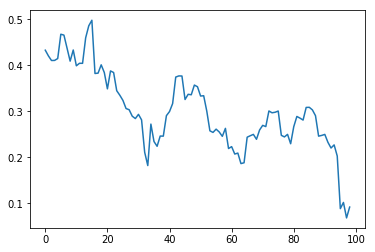

In [8]:
leading_dxy = pd.DataFrame([scaled_dxy.shift(-i) for i in range(0, 11)]).T
vol = leading_dxy.std(axis=1)
plt.plot(vol.values[-n_days:])